A short introduction to fast SPT modeling
-----------------------------------------

This notebook presents a short introduction to the modeling of fast single particle tracking datasets. 
The methodology, together with examples of biological relevance, can be found at:

> Hansen, Anders S., Iryna Pustova, Claudia Cattoglio, Robert Tjian, and Xavier Darzacq. “CTCF and Cohesin Regulate Chromatin Loop Stability with Distinct Dynamics.” bioRxiv, 2016, 093476.

This package includes several sample datasets, that will be used by this notebook. Make sure that they can be found by Python.

## 1. Loading of a dataset

To help us with basic and repeated tasks such as dataset loading, we created a small library, `fastSPT_tools` that contain several helper functions that we will use all across this tutorial. We thus need to import it by typing `import fastSPT_tools`.

One of the functions list the available datasets: `list_sample_datasets(path)`. Let's first see what datasets we can get. Then, we will use the `load_dataset(path, dataset_id, cells)` function to load the relevant dataset. This latter function can either load one single cell or a series of cells (identified by their id).

In [2]:
import sys
from tqdm.autonotebook import tqdm
sys.version

#sys.path.append(r'C:\Users\andre\Documents\Spot-On-cli')

/home/mcm/anaconda3/envs/spoton/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


'3.7.3 (default, Mar 27 2019, 22:11:17) \n[GCC 7.3.0]'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import lmfit

#sys.path.append(r'C:\Users\andre\Documents\Spot-On-cli')

import fastspt as fs
from fastspt import fit, tools, plot, readers, matimport, tracklen
%load_ext autoreload

%autoreload 2

print("Using fastspt version {}".format(fs.__version__))

import logging
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

Using fastspt version 16.4


In [4]:
import os
os.getcwd()

'/home/mcm/Spot-On-Cli'

In [27]:
from glob import glob
import scipy.io

In [33]:
folder = r"/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tracks/Res0.2_Intpercentage_std3_MaxDisp4_rawth2"
#folder = r"Z:\Andrey\data\2019\0403-RAMM-e-coli-pbp2-PAmCherry-TLK130\100x_1.49NA\0403_OD0.1"

data_paths = glob(folder + "/*/*pathsC.mat") # *tracks.xml
print(len(data_paths))

26


In [34]:
data_paths

['/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tracks/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/05-13-RodZ-A22030-hilo/05-13-RodZ-A22030-hilo_GFP-100mW-60msExp-FTo-bleaching-10s-tirf_1-pathsC.mat',
 '/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tracks/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/05-13-RodZ-A22030-hilo/05-13-RodZ-A22030-hilo_GFP-100mW-60msExp-FTo-bleaching-10s-tirf-pathsC.mat',
 '/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tracks/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/05-13-RodZ-A22000/05-13-RodZ-A22000_GFP-100mW-60msExp-FTo-bleaching-10s-tirf_3-pathsC.mat',
 '/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tracks/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/05-13-RodZ-A22000/05-13-RodZ-A22000_GFP-100mW-60msExp-FTo-bleaching-10s-tirf_6-pathsC.mat',
 '/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tra

In [78]:
# Independent experiments
reps = []
data_paths = data_paths[:]
for xml_path in data_paths:
    print(xml_path)
    # reps.append(readers.read_trackmate_xml(xml_path))
    xyft_table = scipy.io.loadmat(xml_path)['paths'][:,:4]
    grouped_tracks = matimport.group_tracks(xyft_table, min_len=3, exposure_ms=60, pixel_size_um=0.08)
    reps.append(grouped_tracks)

/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tracks/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/05-13-RodZ-A22030-hilo/05-13-RodZ-A22030-hilo_GFP-100mW-60msExp-FTo-bleaching-10s-tirf_1-pathsC.mat
175  tracks 
/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tracks/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/05-13-RodZ-A22030-hilo/05-13-RodZ-A22030-hilo_GFP-100mW-60msExp-FTo-bleaching-10s-tirf-pathsC.mat
431  tracks 
/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tracks/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/05-13-RodZ-A22000/05-13-RodZ-A22000_GFP-100mW-60msExp-FTo-bleaching-10s-tirf_3-pathsC.mat
6984  tracks 
/run/user/1000/gvfs/smb-share:server=gaia.pasteur.fr,share=%40mcm/Francois/05-13/Tracks/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/05-13-RodZ-A22000/05-13-RodZ-A22000_GFP-100mW-60msExp-FTo-bleaching-10s-tirf_6-pathsC.mat
5359  tracks 
/run/user/1000/gvfs/smb-share:server=gaia.pasteu

In [85]:
reps[0]

[array([[ 4.3991483 ,  5.515879  ,  2.64      , 44.        ],
        [ 4.36153502,  5.52883785,  2.76      , 46.        ],
        [ 4.35964049,  5.56531947,  2.82      , 47.        ],
        [ 4.35834098,  5.52560111,  2.88      , 48.        ],
        [ 4.41683847,  5.51810277,  2.94      , 49.        ]]),
 array([[ 1.07133804,  5.93323547,  3.48      , 58.        ],
        [ 1.05570645,  5.92450709,  3.42      , 57.        ],
        [ 1.07774723,  5.94093753,  3.3       , 55.        ]]),
 array([[ 2.3424056 ,  5.71027104,  3.54      , 59.        ],
        [ 2.2821148 ,  5.71841296,  3.6       , 60.        ],
        [ 2.30050125,  5.71421535,  3.72      , 62.        ]]),
 array([[ 2.28223556,  5.70646867,  4.38      , 73.        ],
        [ 2.32573456,  5.70297222,  5.4       , 90.        ],
        [ 2.33238814,  5.70415849,  5.34      , 89.        ],
        [ 2.32258074,  5.67945897,  5.28      , 88.        ],
        [ 2.29768157,  5.68936097,  5.22      , 87.        ],
  

# 2. Track lengths analysis

175 tracks, 1414 localizations
Fit result: 255.90 * e^(-x/1.93) + 1.89


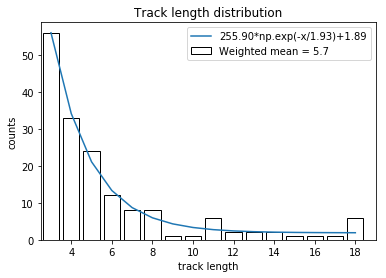

431 tracks, 3046 localizations
Fit result: 630.72 * e^(-x/1.98) + 4.17


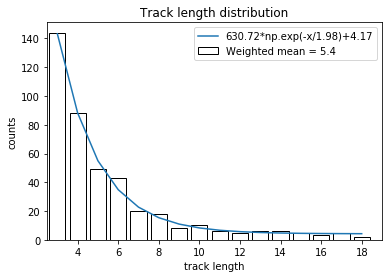

6984 tracks, 51470 localizations
Fit result: 9135.57 * e^(-x/1.97) + 97.46


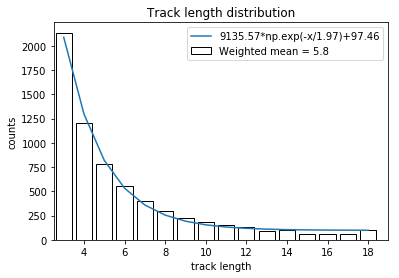

5359 tracks, 37984 localizations
Fit result: 7218.60 * e^(-x/1.97) + 70.72


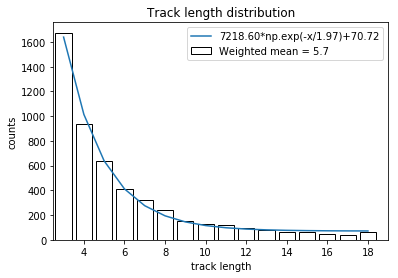

3858 tracks, 26173 localizations
Fit result: 5927.25 * e^(-x/1.88) + 48.78


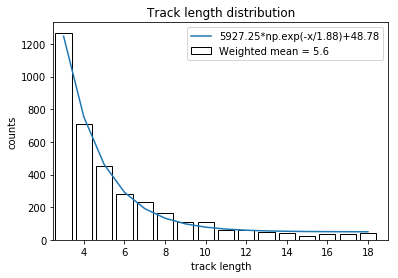

6933 tracks, 49994 localizations
Fit result: 10996.46 * e^(-x/1.79) + 108.39


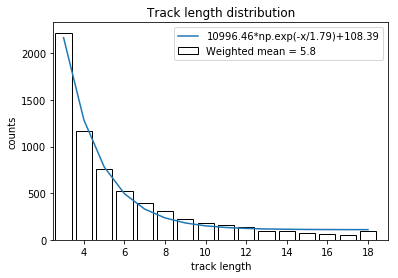

6613 tracks, 49833 localizations
Fit result: 8314.46 * e^(-x/1.99) + 94.19


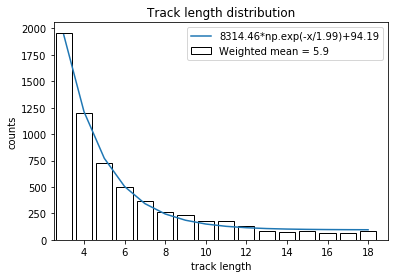

3835 tracks, 27924 localizations
Fit result: 5598.56 * e^(-x/1.85) + 60.60


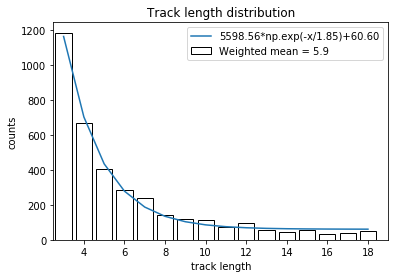

7003 tracks, 76060 localizations
Fit result: 7357.08 * e^(-x/2.19) + 83.85


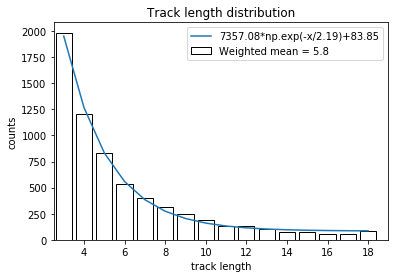

3506 tracks, 41493 localizations
Fit result: 3901.69 * e^(-x/2.08) + 48.60


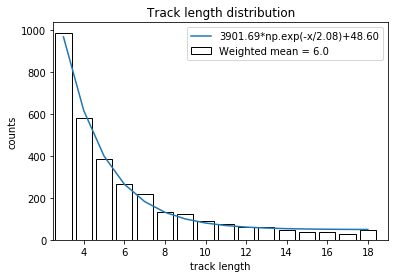

13258 tracks, 115116 localizations
Fit result: 11716.98 * e^(-x/2.39) + 159.31


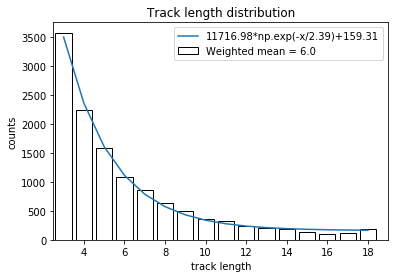

9648 tracks, 80310 localizations
Fit result: 8116.83 * e^(-x/2.43) + 125.45


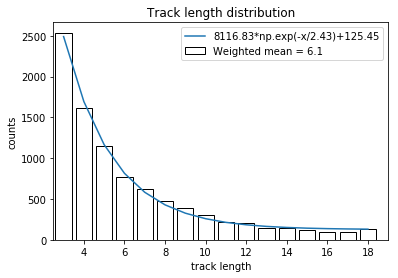

13860 tracks, 115111 localizations
Fit result: 15362.87 * e^(-x/2.10) + 197.27


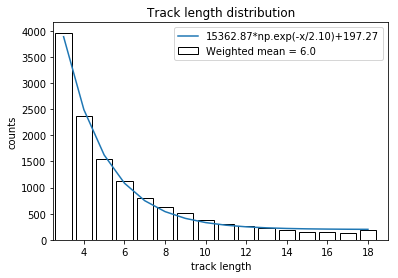

20179 tracks, 175260 localizations
Fit result: -39510526.34 * e^(-x/-167882.65) + 39514159.32


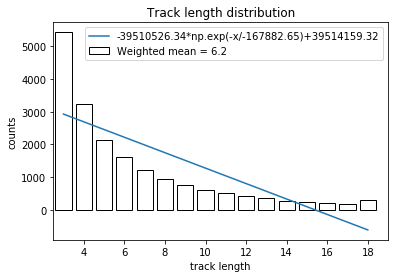

18673 tracks, 166454 localizations
Fit result: 15465.29 * e^(-x/2.39) + 270.79


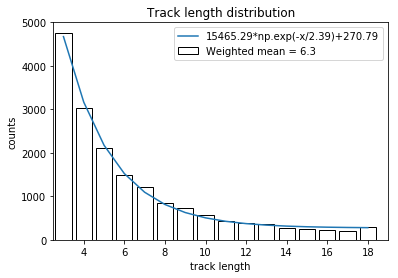

15936 tracks, 145356 localizations
Fit result: 15987.18 * e^(-x/2.13) + 259.52


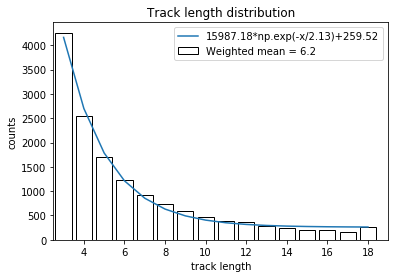

2771 tracks, 17856 localizations
Fit result: 5523.06 * e^(-x/1.69) + 35.02


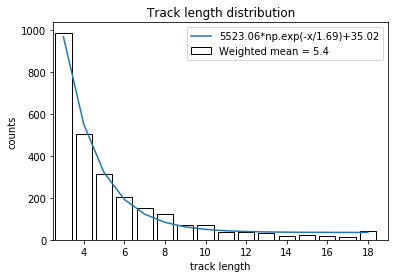

3274 tracks, 21803 localizations
Fit result: 5246.31 * e^(-x/1.83) + 45.78


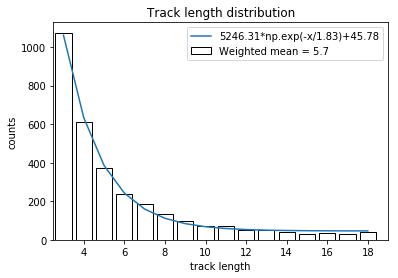

2522 tracks, 17129 localizations
Fit result: 3917.32 * e^(-x/1.86) + 32.97


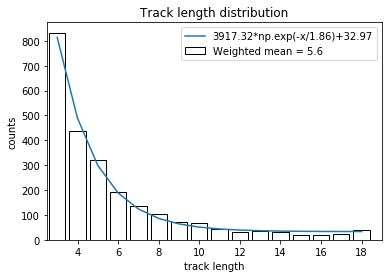

3283 tracks, 22683 localizations
Fit result: 4383.65 * e^(-x/1.98) + 42.99


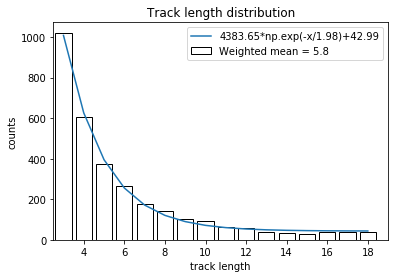

1900 tracks, 11373 localizations
Fit result: 3608.29 * e^(-x/1.79) + 16.29


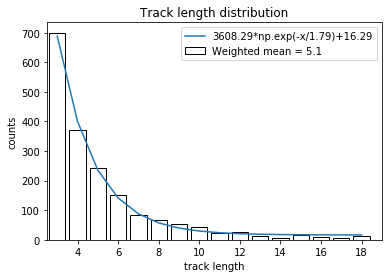

5181 tracks, 38885 localizations
Fit result: 6246.58 * e^(-x/2.11) + 56.24


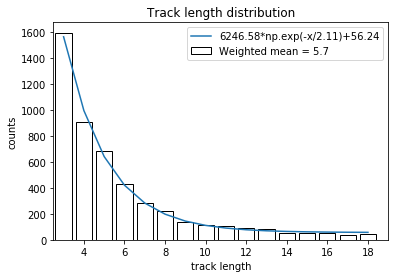

4380 tracks, 35990 localizations
Fit result: 5186.27 * e^(-x/2.05) + 61.27


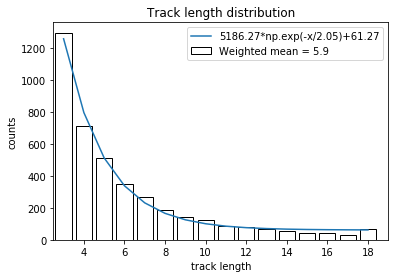

6838 tracks, 51623 localizations
Fit result: 9537.90 * e^(-x/1.92) + 96.20


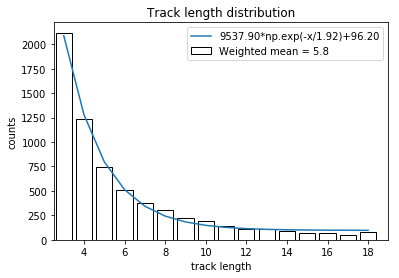

6395 tracks, 53340 localizations
Fit result: 8024.53 * e^(-x/1.98) + 94.06


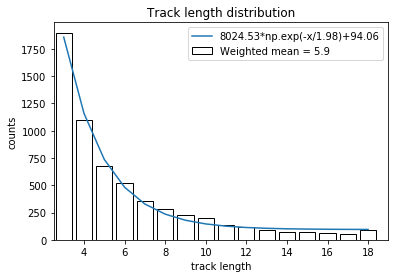

6122 tracks, 48615 localizations
Fit result: 7810.43 * e^(-x/1.99) + 84.14


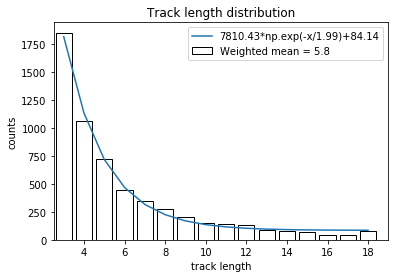

In [80]:
for rep in reps:
    tracklen.get_track_lengths_dist(rep, plot=True)

In [84]:
readers.to_fastSPT(reps[0], from_json=False)

array([(array([[4.3991483 , 5.515879  ],
       [4.36153502, 5.52883785],
       [4.35964049, 5.56531947],
       [4.35834098, 5.52560111],
       [4.41683847, 5.51810277]]), array([[2.64, 2.76, 2.82, 2.88, 2.94]]), array([[44, 46, 47, 48, 49]], dtype=uint16)),
       (array([[1.07133804, 5.93323547],
       [1.05570645, 5.92450709],
       [1.07774723, 5.94093753]]), array([[3.48, 3.42, 3.3 ]]), array([[58, 57, 55]], dtype=uint16)),
       (array([[2.3424056 , 5.71027104],
       [2.2821148 , 5.71841296],
       [2.30050125, 5.71421535]]), array([[3.54, 3.6 , 3.72]]), array([[59, 60, 62]], dtype=uint16)),
       (array([[2.28223556, 5.70646867],
       [2.32573456, 5.70297222],
       [2.33238814, 5.70415849],
       [2.32258074, 5.67945897],
       [2.29768157, 5.68936097],
       [2.30923406, 5.73281912],
       [2.32668662, 5.71234283],
       [2.3073535 , 5.69563158],
       [2.32550275, 5.66930406],
       [2.32401358, 5.68547713],
       [2.3587209 , 5.73859797],
       [2.30167

## 3. Fitting of the jump lengths distribution to the model (2 states)


In [89]:
## Generate a dictionary of parameters
fit_params = dict(states=2,
                 iterations=1,
                 CDF=False,
                 CDF1 = True,
                 Frac_Bound = [0, 1],
                 D_Free = [0.02, 0.1],
                 D_Med = [0.005, 0.1],
                 D_Bound = [0.0, 0.005],
                 sigma = 0.02,
                 sigma_bound = [0.005, 0.1],
                 fit_sigma=True,
                 dT=0.06,
                 dZ=0.7,
                 a=0.15716,
                 b=0.20811,
                 useZcorr=False,
                 plot_hist=False,
                 plot_result=True) 


def my_fit(rep):
    
    cell_spt = readers.to_fastSPT(rep, from_json=False)
    fit_result = tools.auto_fit(cell_spt,
                                fit_params=fit_params)
    return fit_result

reps_fits = list(map(my_fit, reps))


DEBUG:fastspt.fit:useAllTraj = False
DEBUG:fastspt.fit:len(trackedPar) = 175
/home/mcm/Spot-On-Cli/fastspt/fit.py:228: RuntimeWarning: overflow encountered in ushort_scalars
  _dist = pdist(CurrXY_points)
ERROR:fastspt.fit:Index error happened  in TransLengths[CurrFrameJump-1]["Step"].append(_dist), CurrFrameJump = 65535, len(TransLengths) = 15, trackedPar[i][2][0][k+n] = 57, trackedPar[i][2][0][k] = 58


Number of frames: 1000.0, number of localizations: 1414


IndexError: list index out of range

In [37]:
#get stats
fit_stats = pd.DataFrame(columns=list(reps_fits[0].best_values.keys()) + ['chi2', 'num_tracks'])

for i, fit_result in enumerate(reps_fits):
    name = data_paths[i].split("/")[-2]
    # name = f'rep {i+1}'
    fit_stats.loc[f'{name}'] = list(fit_result.best_values.values()) + [fit_result.chisqr, len(reps[i])]

fit_stats.loc['mean'] = fit_stats.mean(axis=0)
fit_stats.loc['std'] = fit_stats.std(axis=0)

#fit_stats.to_json(folder + '\stats.json')

fit_stats
#fit_stats.to_excel(path_oe + '.stats.xls')

IndexError: list index out of range

In [19]:
# save stats

fit_stats.to_json(folder + '\stats.json')

In [97]:
# remove bad fits
stats_filtered = fit_stats[fit_stats.chi2 < 0.01]
stats_filtered.to_json(folder + '\stats_chi2_better_than_0.01.json')
stats_filtered

,D_free,D_bound,F_bound,sigma,chi2,num_tracks
"['FOV1', 'movie_Ard_trig_v1.0_exp_60ms_561_50W_30ms_405_12.5mW_0.8ms_1']",0.061961,3.581161e-04,0.283051,0.047220,0.004957,1910.000000
"['FOV5', 'movie_continuos_exp_60ms_561_50W_405_12.5mW_1']",0.100000,7.438494e-17,0.235892,0.054208,0.005529,16449.000000
"['FOV7', 'movie_continuos_exp_60ms_561_50W_405_12.5mW_1']",0.068401,1.004699e-03,0.290912,0.049450,0.001203,9115.000000
mean,0.078304,3.407038e-04,0.366257,0.046612,0.007740,7115.500000
std,0.014634,4.102898e-04,0.168127,0.006856,0.006861,6240.106349


In [55]:
import json

In [58]:
json.dump(fit_params, open(folder + '\params.json', 'x'))

In [16]:
pd.read_json(r"Z:/Andrey/fromGizem/2019-04-18-PBP2-tracks/PBP2OverExpforAndrey.mat.stats.json",)

,D_fast,D_med,D_bound,F_fast,F_bound,sigma,chi2
mean,0.036449,0.011052,1.067581e-04,0.547984,0.123352,0.019759,0.001334
rep 1,0.036826,0.010664,1.053494e-04,0.521843,0.128585,0.019831,0.001504
rep 2,0.041200,0.015000,2.149249e-04,0.467069,0.124263,0.020219,0.001203
rep 3,0.031321,0.007492,7.549517e-17,0.655040,0.117209,0.019227,0.001295
std,0.004042,0.003078,8.774840e-05,0.078933,0.004689,0.000408,0.000126
